<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_LSTM_Avec_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce carnet nous allons mettre en place un modèle à réseau de neurones récurrent de type LSTM pour réaliser des prédictions sur notre série temporelle.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle

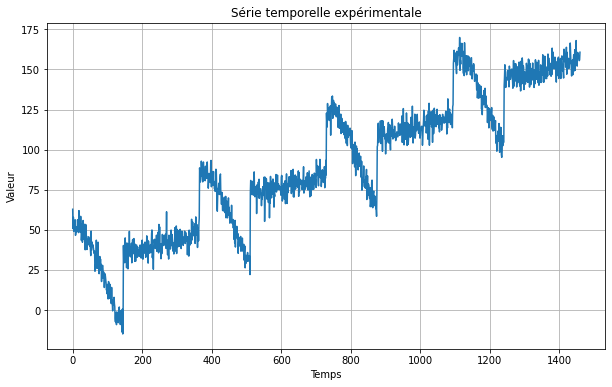

In [2]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit)

plt.figure(figsize=(10, 6))
affiche_serie(temps,serie)
plt.title('Série temporelle expérimentale')
plt.show()

# Préparation des données X et Y

In [3]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.shuffle(buffer_melange).map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

**1. Séparation des données en données pour l'entrainement et la validation**

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Images/Series/illustration1.png?raw=true" width="600">  

In [4]:
temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

**2. Préparation des données X et des labels Y**

On commence par créer notre dataset à partir de la série (remarque : les valeurs ci-dessous sont en réalité mélangées) :

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/split_XY_2.png?raw=true" width="1200"> 

In [5]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 20
batch_size = 32
buffer_melange = 1000

# Création du dataset X,Y
dataset = prepare_dataset_XY(serie,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val = prepare_dataset_XY(x_validation,taille_fenetre,batch_size,buffer_melange)

# Création du modèle simple couche LSTM

**1. Création du réseau et adaptation des formats d'entrée et de sortie**

Le réseau que nous allons mettre en place est un réseau de neurones récurrent, composé de :
  - Une couche d'entrée récurrente de type LSTM à 40 neurones, de type séquence vers vecteur
  - Une couche de sortie dense avec 1 neurone

Pour adapter les données en entrée et en sortie du réseau au format attendu, nous allons utiliser une [couche de type lambda](https://keras.io/api/layers/core_layers/lambda/) avec Keras. Ce type de couche nous permet d'intégrer une fonction spécifique en tant que couche dans notre réseau de neurone.

- En entrée de la première couche récurrente, le format attendu est de type : [batch_size, #instants, #dims].   
Le **format d'entrée attendu est donc [None,None,1]** car notre série temporelle est de type univariée, qu'on souhaite pouvoir traiter une séquence infinie, et que le batch size est géré automatiquement par tensorflow.  
Il faut donc en entrée transformer le format [taille_fenetre, 1] vers le format [None, None, 1].  

- En sortie de la deuxième couche récurrente, le format est de type [batch_size, #instants, #neurones]. Il sera de type [None, None, 40].  
- La couche dense possède un seul neurone. En **sortie de la couche dense, le format est de type [None, None, 1]**.

Sous Keras, nous allons utiliser une couche récurrente de type LSTM avec la classe [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/). En sortie, la fonction d'activation par défaut est de type `tanh` qui sort une sortie comprise entre [-1,1]. Comme notre série possède des valeurs autour de 100, nous allons faire en sorte d'étendre la plage des valeurs en sortie de la couche dense en les multipliant par 100.

Sous forme de shéma, notre réseau est donc le suivant :


<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/LSTM_1.png?raw=true" width="1200"> 

Pour insérer une dimension de type `None` au format de l'entrée, on utilise la méthode [expand_dims](https://www.tensorflow.org/api_docs/python/tf/expand_dims) de tensorflow. 

In [140]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

In [121]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/uzaymacar/attention-mechanisms/master/layers.py

--2021-03-08 17:45:36--  https://raw.githubusercontent.com/uzaymacar/attention-mechanisms/master/layers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21419 (21K) [text/plain]
Saving to: ‘layers.py’

layers.py           100%[===================>]  20.92K  --.-KB/s    in 0s      

2021-03-08 17:45:37 (100 MB/s) - ‘layers.py’ saved [21419/21419]



In [ ]:
# Self attention

from layers import Attention, SelfAttention

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)


inputs = tf.keras.Input(batch_shape=(None,None,1))
encoder_output, hidden_state, cell_stat =tf.keras.layers.LSTM(units=40,return_sequences=True,return_state=True)(inputs)

attention_input = [encoder_output, hidden_state]
encoder_output, attention_weights = SelfAttention(size=20,num_hops=16,use_penalization=False)(encoder_output)

outputs = tf.keras.layers.Dense(1,trainable=True)(encoder_output)

out = tf.keras.layers.Lambda(Traitement_Sorties)(outputs)
model=tf.keras.Model(inputs,outputs)

model.summary()


In [153]:
# Global attention

from layers import Attention, SelfAttention

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)


inputs = tf.keras.Input(batch_shape=(None,None,1))
encoder_output, hidden_state, cell_stat =tf.keras.layers.LSTM(units=40,return_sequences=True,return_state=True)(inputs)

attention_input = [encoder_output, hidden_state]

encoder_output, attention_weights = Attention(context='many-to-one',alignment_type='global')(attention_input)
outputs = tf.keras.layers.Dense(1,trainable=True)(encoder_output)

out = tf.keras.layers.Lambda(Traitement_Sorties)(outputs)
model=tf.keras.Model(inputs,outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, None, 40), ( 6720        input_6[0][0]                    
__________________________________________________________________________________________________
attention_5 (Attention)         ((None, None, 40), ( 1600        lstm_5[0][0]                     
                                                                 lstm_5[0][1]                     
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, None, 1)      41          attention_5[0][0]            

In [162]:
# Local p* attention

from layers import Attention, SelfAttention

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)


inputs = tf.keras.Input(batch_shape=(None,taille_fenetre,1))
encoder_output, hidden_state, cell_stat =tf.keras.layers.LSTM(units=40,return_sequences=True,return_state=True)(inputs)

attention_input = [encoder_output, hidden_state]

encoder_output, attention_weights = Attention(context='many-to-one', alignment_type='local-p*', window_width=taille_fenetre)(attention_input)

outputs = tf.keras.layers.Dense(1,trainable=True)(encoder_output)

out = tf.keras.layers.Lambda(Traitement_Sorties)(outputs)
model=tf.keras.Model(inputs,outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 20, 40), (No 6720        input_6[0][0]                    
__________________________________________________________________________________________________
attention_5 (Attention)         ((None, 20, 40), (No 3240        lstm_5[0][0]                     
                                                                 lstm_5[0][1]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 20, 1)        41          attention_5[0][0]          

**2. Optimisation du taux d'apprentissage**

In [165]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()


In [167]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/100
45/45 [==============================] - 2s 8ms/step - loss: 83.5838 - mae: 84.0835

Epoch 00001: loss improved from inf to 90.06552, saving model to poids.hdf5


RuntimeError: ignored

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

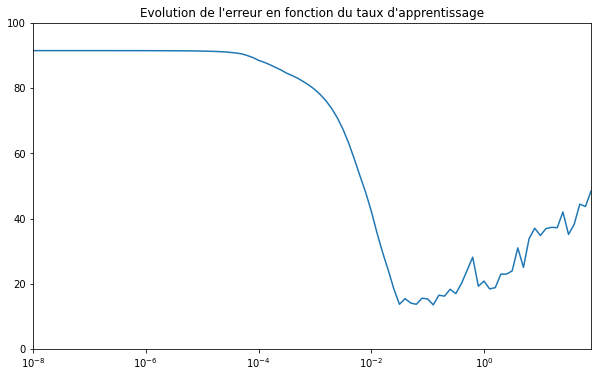

In [156]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 100])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [131]:
# Remise à zéro des états du modèle
tf.keras.backend.clear_session()

In [132]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [133]:
# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(lr=1.1e-3)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset,validation_data=dataset_Val, epochs=500,verbose=1, callbacks=[CheckPoint])

Epoch 1/500
45/45 [==============================] - 3s 23ms/step - loss: 4.5629 - mae: 5.0373 - val_loss: 4.9910 - val_mae: 5.4742

Epoch 00001: loss improved from inf to 4.42506, saving model to poids.hdf5
Epoch 2/500
45/45 [==============================] - 1s 13ms/step - loss: 4.4965 - mae: 4.9714 - val_loss: 4.7062 - val_mae: 5.1816

Epoch 00002: loss improved from 4.42506 to 4.36252, saving model to poids.hdf5
Epoch 3/500
45/45 [==============================] - 1s 14ms/step - loss: 4.1737 - mae: 4.6479 - val_loss: 5.6024 - val_mae: 6.0872

Epoch 00003: loss improved from 4.36252 to 4.28970, saving model to poids.hdf5
Epoch 4/500
45/45 [==============================] - 1s 14ms/step - loss: 4.4321 - mae: 4.9047 - val_loss: 4.5269 - val_mae: 4.9986

Epoch 00004: loss improved from 4.28970 to 4.25515, saving model to poids.hdf5
Epoch 5/500
45/45 [==============================] - 1s 14ms/step - loss: 4.4983 - mae: 4.9744 - val_loss: 4.6401 - val_mae: 5.1182

Epoch 00005: loss did n

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

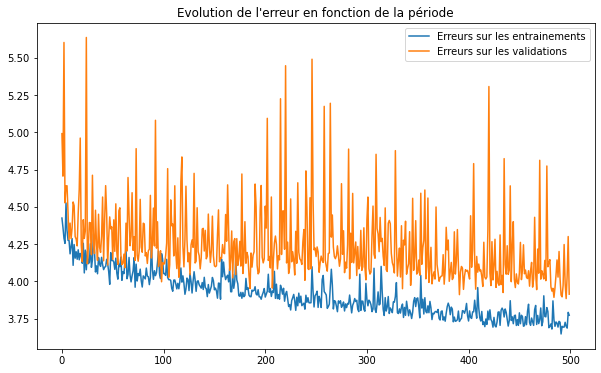

In [134]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

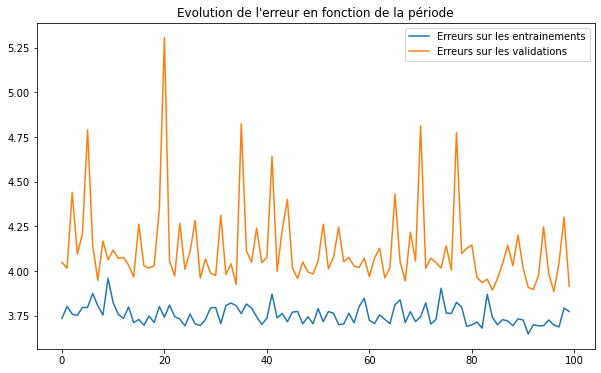

In [135]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

Puisque le format d'entrée permet de prendre des séquences infinies, nous pouvons entrer des séquences de n'importe quelle taille :

In [136]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [ ]:
X = np.reshape(serie[0:20],(1,20))
model.predict(X)

In [137]:
taille_fenetre = 20

# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(serie[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

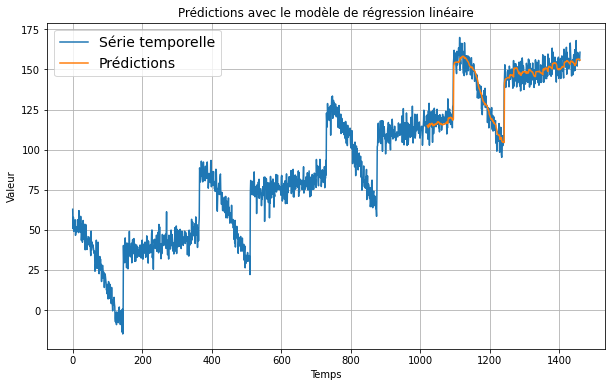

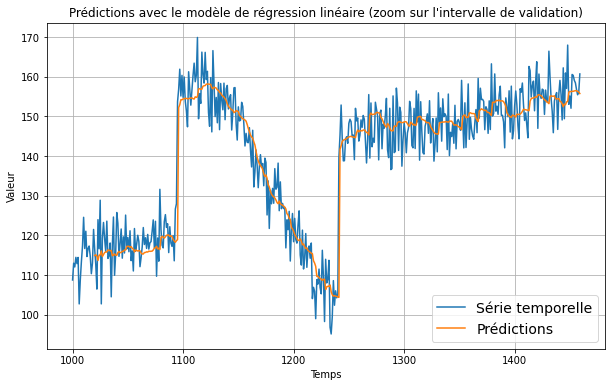

In [138]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle de régression linéaire')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle de régression linéaire (zoom sur l'intervalle de validation)")
plt.show()

In [139]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()

print(mae)
print(mse)

4.4185963
34.370323


# Création du modèle double couche LSTM

**1. Construction du modèle**

Sous forme de shéma, notre réseau est donc le suivant :

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/LSTM_2.png?raw=true" width="1200"> 

In [ ]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(None,)))
model.add(tf.keras.layers.Lambda(Traitement_Entrees))
model.add(tf.keras.layers.LSTM(40,return_sequences=True))
model.add(tf.keras.layers.LSTM(40))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Lambda(Traitement_Sorties))

model.save_weights('model_initial.h5')

model.summary()

**2. Optimisation du taux d'apprentissage**

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/20)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/20))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([taux[0], taux[99], 0, 100])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [ ]:
# Remise à zéro des états du modèle
tf.keras.backend.clear_session()

# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=4e-6, momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset,validation_data=dataset_Val, epochs=500,verbose=1, callbacks=[CheckPoint])

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

In [ ]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [ ]:
taille_fenetre = 20

# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(serie[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

In [ ]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle de régression linéaire')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle de régression linéaire (zoom sur l'intervalle de validation)")
plt.show()

In [ ]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()

print(mae)
print(mse)

# Création du modèle double couche LSTM Bi-directionnel

**1. Construction du modèle**

In [ ]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(None,)))
model.add(tf.keras.layers.Lambda(Traitement_Entrees))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40)))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Lambda(Traitement_Sorties))

model.save_weights('model_initial.h5')

model.summary()

**2. Optimisation du taux d'apprentissage**

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([taux[0], taux[99], 0, 100])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [ ]:
# Remise à zéro des états du modèle
tf.keras.backend.clear_session()

# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(lr=1e-3)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset,validation_data=dataset_Val, epochs=500,verbose=1, callbacks=[CheckPoint])

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

In [ ]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [ ]:
taille_fenetre = 20

# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(serie[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

In [ ]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle de régression linéaire')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle de régression linéaire (zoom sur l'intervalle de validation)")
plt.show()

In [ ]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()

print(mae)
print(mse)

In [ ]:
# Chargement des poids sauvegardés
model.load_weights("model_initial.h5")